## Geologic model of Gottesacker from scratch in GemPy
Run in GK2 environment
***
This model uses a DEM raster to set the model extent and resolution. All cropping and plotting functions require that the model resolution match the DEM resolution. If you want a different model resolution, resample the DEM raster FIRST, then use the resampled DEM to build the model.
***
**Files needed**
<br>- interfaces.csv - must have at least 2 pts per unit, column headings (case-sensitive): X, Y, Z, formation. XYZ must be numbers not strings, for pt coordinates. formation is the formation name string.
<br>- orientations.csv - must have at least 1 pt per unit, column headings (case-sensitive): X, Y, Z, azimuth, dip, polarity, formation. azimuth=strike in degrees east of north, polarity=1
<br>- DEMraster.tif - digital elevation model raster file

***
**To-do:**
<br>- figure out how to efficiently get points from a geologic map
<br> --> enable interactive point picking using bokeh (or matplotlib?) - set formation first, then pick points interactively and append them to the dataframe for that formation, then run function again for each formation
<br>- add ability to create points by adding or subtracting a formation's thickness from a point on the overlying or underlying formation?

***
**Notes:**
<br>- *IMPORTANT:* Nico's geologic map has x coordinates that have an extra '3' at the beginning. This has to be removed in order to get normal UTM coordinates. Why?
<br>- orientation data is taken from strike & dip measurements at the land surface, reported on Nico's map (map was georeferenced, and elevation was taken from DEM at location of s&d measurement). 1m was added to the top of the Schrattenkalk when it is at the land surface to account for erosion.
<br>- interface data is taken by georeferencing a cross-section, and subtracting the thickness of the desired layer from the surface elevation (as given by the DEM). At all points where the top of the Schrattenkalk was at the land surface, 1m was added to account for erosion. Missing formations were added by poaching points from the interface data.
<br>- for consistency, all elevations and coordinates are taken from the unclipped 50m DEM raster (because clipping sometimes requires resampling).
<br>- pymc package downgrades numpy, so it's not worth adding it


## Imports & Setup

In [1]:
# Import packages:

import sys, os
import numpy as np
import pandas as pn
import matplotlib.pyplot as plt
import matplotlib
import theano
#import geopandas as geo
import gdal
from copy import copy
import importlib

sys.path.append("../../..")   #optional: if gempy has been downloaded from GitHub rather than installed normally, look for it in the folders above the current folder
import gempy as gp

import mapping   #import local mapping module add-on

#embed matplotlib figures into notebooks:
%matplotlib inline            

../../..\gempy\plotting\visualization.py:36: UserWarning: Steno 3D package is not installed. No 3D online visualization available.
  warnings.warn('Steno 3D package is not installed. No 3D online visualization available.')
../../..\gempy\posterior_analysis.py:24: UserWarning: pymc (v2) package is not installed. No support for stochastic simulation posterior analysis.
  warnings.warn("pymc (v2) package is not installed. No support for stochastic simulation posterior analysis.")
../../..\gempy\posterior_analysis.py:28: UserWarning: pymc (v3) package is not installed. No support for stochastic simulation posterior analysis.
  warnings.warn("pymc (v3) package is not installed. No support for stochastic simulation posterior analysis.")


In [132]:
importlib.reload(mapping)

<module 'mapping' from 'C:\\Users\\Chloe\\Documents\\GitHub\\gempy\\notebooks\\prototype_notebooks\\Chloe_Gottesacker\\mapping.py'>

In [142]:
#Set filenames:

DEM_filename =          'DEMraster50_251x200.tif'        #DEM to be used to set model grid (should be rectangular)
interfaces_filename =   'GK_interfaces.csv'              #interfaces csv file (must have columns:   X, Y, Z, formation)
orientations_filename = 'GK_orientations.csv'            #orientations csv file (must have columns: X, Y, Z, azimuth, dip, polarity, formation)
cropping_filename =     'DEMraster50_clip_251x200.tif'   #DEM to be used to clip model to an irregular polygonal XY extent

Raster dimensions: 
xmin: 578287.5     xmax: 590837.5     xres: 251 
ymin: 5240062.5    ymax: 5250062.5    yres: 200 
zmin: 913.0        zmax: 2230.0       zres: na


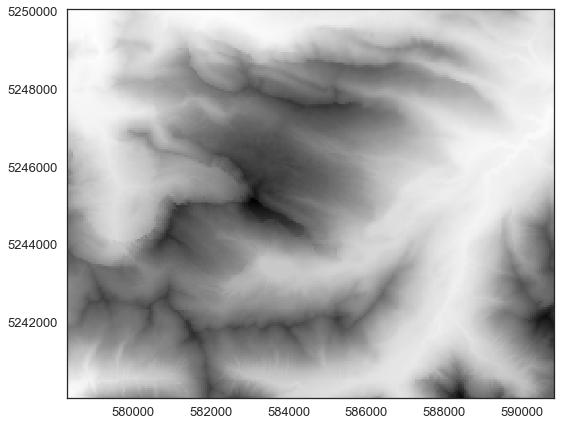

In [138]:
#Get and assign grid and resolution based on DEM raster file:
dem,dema,xmin,xmax,xres,dx,ymin,ymax,yres,dy,zmin,zmax,zres = mapping.importDEM(DEM_filename,show=True)        
zres = 100             #manually assign a z resolution to use for the model (this has nothing to do with the dem resolution)
dz = (zmax-zmin)/zres  #calculate z cell height (kind of like contour interval)

grid_info = [xmin,xmax,xres,dx,ymin,ymax,yres,dy,zmin,zmax,zres,dz]  #lump grid and resolution info into one list to use later

In [5]:
#googlemap files include a fault!
#geo_dat resolution does NOT have to match DEM resolution, but many plotting functions will not work well if they are different
#for quick computation, assign a lower resolution by doing integer division on the DEM xres and yres

geo_data = gp.InputData([xmin,xmax, ymin,ymax, zmin,zmax], [xres,yres,zres],      #set x,y,z min and max extent, and x,y,z resolution (can use info from DEM but must be integers)
                       path_i=interfaces_filename,                  #csv file for interface points: must be at bottom of a layer, col names are case sensitive, must include at least 2 points per unit
                       path_o=orientations_filename)       #csv file for orientation points: col names are case sensitive, must include at least one point per unit 

In [6]:
# View geologic info:
print(gp.get_data(geo_data, itype='formations'))   #list formations
geo_data.interfaces.head()                  #display first few rows of geo_data dataframe
#gp.plot_data(geo_data)                      #plot geo_data
#gp.plot_data_3D(geo_data)                   #plot geo_data in 3D using VTK (optional) (note: when a VTK interactive window is open, nothing else in the notebook can run - pause or close the window before continuing)

               value  formation_number
Drusberg           1                 1
Garschella         2                 2
Schrattenkalk      3                 3
basement           4                 4


,X,Y,Z,formation,series,formation_number,order_series,isFault,annotations,formation_value
0,583905.77,5247005.54,1506.0,Drusberg,Default series,1,1,False,"${\bf{x}}_{\alpha \,{\bf{1}},0}$",1
7,584508.03,5248353.39,1198.0,Drusberg,Default series,1,1,False,"${\bf{x}}_{\alpha \,{\bf{1}},1}$",1
1,584001.68,5247223.82,1526.0,Drusberg,Default series,1,1,False,"${\bf{x}}_{\alpha \,{\bf{1}},2}$",1
2,584124.05,5247498.33,1613.0,Drusberg,Default series,1,1,False,"${\bf{x}}_{\alpha \,{\bf{1}},3}$",1
3,584236.50,5247746.37,1710.0,Drusberg,Default series,1,1,False,"${\bf{x}}_{\alpha \,{\bf{1}},4}$",1


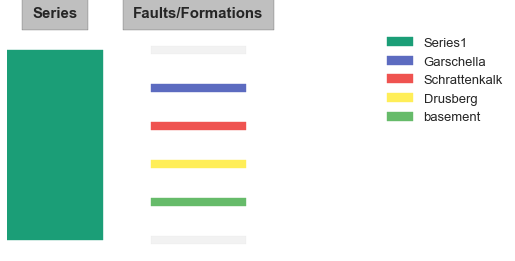

In [7]:
#Set series and formations stratigraphy for viewing:
#to-do: see how hard it would be to make colors customizable

#if using googlemap files:
#gp.set_series(geo_data, {'Fault1': 'fault',  'Rest': ['Garschella', 'Schrattenkalk', 'Drusberg']}, verbose=1)  #series indicate BOTTOM of named layer

#if using arcmap files:
unitnames = ['Garschella', 'Schrattenkalk', 'Drusberg']   #list unit name strings IN ORDER (youngest to oldest)!!!!
gp.set_series(geo_data, {'Series1': unitnames}, verbose=1)                        #series indicate BOTTOM of named layer


In [9]:
print(gp.get_data(geo_data, itype='formations'))   #list formations with updated order and numbers

               value  formation_number
Garschella         1                 1
Schrattenkalk      2                 2
Drusberg           3                 3
basement           4                 4


## Create model

In [10]:
# Interpolate data:
#Caution: takes a while because has to compile. 
#only have to compile once UNLESS change presence of faults or not (number of faults doesn't matter - can change the number of fms & faults afterwards)
#but have to compile after data is imported 
#if changes are made to geo_data after this step, use update_interpolator (see below)
#do you need to recompile if the resolution is changed?
#defaults to float32 - use dtype='float64' to add precision (slower)
#common problems: list of formations doesn't match formations in data files, don't have minimum required points per formation


interp_data = gp.InterpolatorData(geo_data, compile_theano=True,
                                  theano_optimizer='fast_compile', is_lith=True, is_fault=False)


Compiling theano function...
Compilation Done!
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float32
Number of faults:  0


In [9]:
# Optional: if changes are made to geo_data, can update interpolation without re-compiling:
interp_data.update_interpolator(geo_data)    

In [11]:
# Compute model: 
is_fault = False        #set whether fault is present

if is_fault == False:   #if no fault
    lith = gp.compute_model(interp_data)  #lith is two arrays (each with dim: model extent) with a formation number assigned to each cell, and the orientation of that formation at each cell
    #note: format of lith seems to change if fault is present or not, so may need to index differently to get the right slice
    #note: lith includes some non-integer formation values at boundaries - this is OK
if is_fault == True:   #if there is a fault
    # Optional: set faults to be finite:
    inf_factor = interp_data.interpolator.tg.inf_factor.get_value()     #fault extent is controlled by an infinity factor (default=10, which is larger than model scale)
    inf_factor[0]=0                                                     #set infinity factor to 0 to make faults finite
    interp_data.interpolator.tg.inf_factor.set_value(np.zeros(10, dtype="int32"))   #update value 
    interp_data.interpolator.tg.inf_factor.get_value()                              #display new values
    lith, fault = gp.compute_model(interp_data)
    


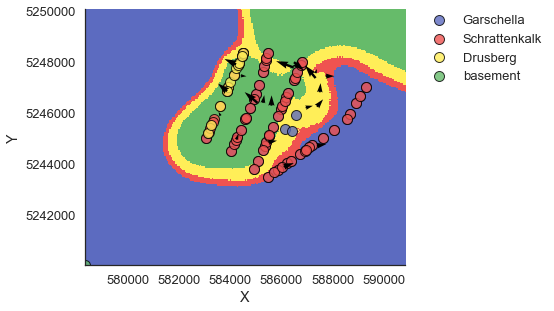

In [12]:
# Display model results:
gp.plotting.plot_section(geo_data, lith[0][0], 25, plot_data=True, direction='z')   #plot 2D x-sec (block must equal an array of formation numbers)
#ver, sim = gp.get_surfaces(interp_data, lith[0][1])                       #create 3D objects for plotting
#gp.plotting.plot_surfaces_3D_real_time(geo_data, interp_data, ver, sim)    #display in 3D with VTK
#note: this will leave this code block hanging - need to close or pause the VTK window to continue

## Project and crop with topography

Uses the information from the DEM used to set the model resolution and extent. Will not work if the DEM extent doesn't match the model extent.

In [154]:
#Format data for plotting:

#Get values for lith unit at the surface, and format data so it can be plotted as a geologic map
#(discretize into a 3D (xyz) array with cell values indicating lithology):
surflith, surflist = mapping.get_surflith(dem, dema, interp_data, grid_info)            #get lith at surface
surflithxycrop = mapping.crop2raster(surflith, grid_info, cropping_filename, nanval=0)  #crop surface lith to raster

#Discretize model vertically (useful for x-sec plotting) and remove model values above land surface:
lithzcrop = mapping.crop2elevation(lith[0][0], dema, grid_info)

#Crop to a different raster extent (for example a watershed boundary) (optional):
lithxycrop = mapping.crop2raster(lithzcrop, grid_info, cropping_filename, nanval=0)

In [140]:
#Format lith for export to SKS:
#overall model dimensions:         x: 251  y: 200,  z: 100
#surflist: 1D array of lithology values at land surface (for a 2D geologic model)

def export2gslib(export_filename, lith_array, grid_info):
    '''Export a lithology array to a gslib format that can be used with SKS (GeoModeller format).
    Inputs: 
    export_filename: name string of file to create (ex: 'surfgeo.csv')
    lith_array:      1D array of lithology values (for example, surflist returned by get_surflith()). Should have dimensions (xres*yres)
    grid_info:       [xmin,xmax,xres,dx,ymin,ymax,yres,dy,zmin,zmax,zres,dz] array of model grid and resolution info from importDEM()   
    
    Outputs:
    'geo.gslib':     csv gslib file of dimensions (2,xres*yres) with lithology integer values for each cell, formatted for SKS (GeoModeller format)
    '''
    
    #Get grid info:
    xres = grid_info[2]
    yres = grid_info[6]
    
    g = np.reshape(lith_array,(yres,xres)) #reshape 1D lith array to an array with dimensions (yres,xres)
    #print(np.shape(g))                     #print shape to check that reshape worked correctly (should be (xres,yres))
    g = np.flip(g,axis=0)                  #flip y axis 
    g = np.reshape(g,yres*xres)            #reshape 2D array back to 1D array
    #print(np.shape(g))                     #print shape to check that reshape worked correctly (should be (xres*yres))
    df = pn.DataFrame(g)                   #store in a pandas dataframe
    df = np.round(df)                      #round formation values to closest integer
    df = df.astype(np.int)                 #convert floats to integers

    df.to_csv(export_filename, header=False)               #export to csv
    #df.to_csv('surfgeo.gslib')             #export to csv wih gslib extension

export_filename = 'surfgeo.gslib'
lith_array = surflist
export2gslib(export_filename, lith_array, grid_info)

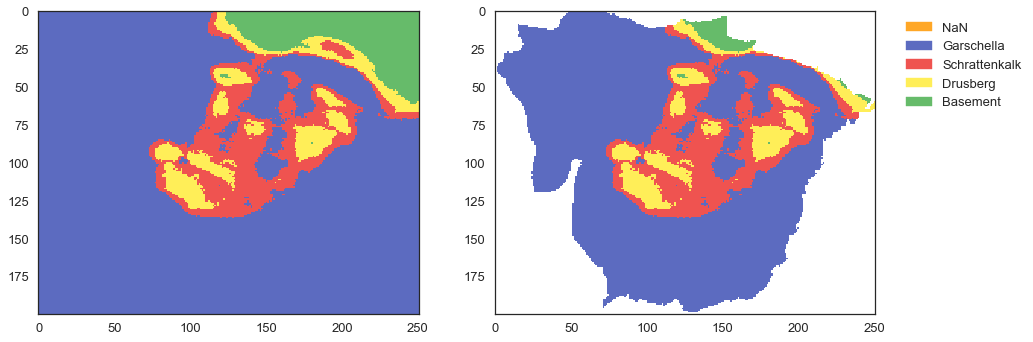

In [162]:
#Plot GemPy geologic map (uncropped and cropped):
f,ax = plt.subplots(1,2,figsize=(15,10))
names,colors,cmap,norm = mapping.set_colorscheme('GemPy')
plt.axes(ax[0])                                   #set axis to first axis
plt.imshow(surflith, cmap=cmap, norm=norm)        #plot geology (normalized to gempy color range)
plt.axes(ax[1])                                   #set axis to first axis
plt.imshow(surflithxycrop, cmap=cmap, norm=norm)        #plot geology (normalized to gempy color range)
patches = [matplotlib.patches.Patch(color=colors[i], label=names[i]) for i in range(len(names))] #set up legend by plotting patches (GemPy cmap)
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2) #put patches into legend & set location

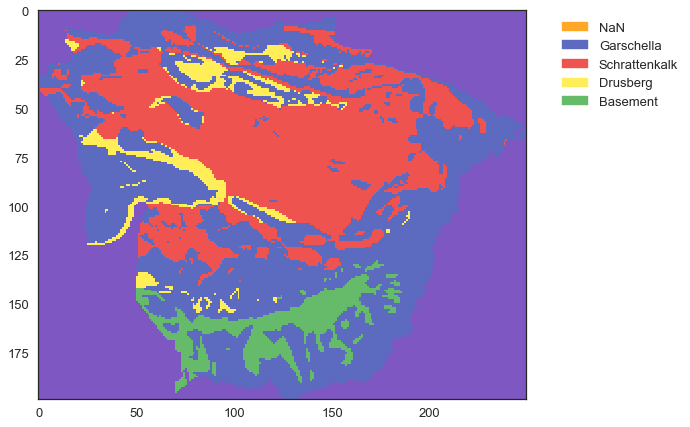

In [146]:
#Import true geologic map raster:
#note: geology raster should have the same xy cell size as GemPy
#note: this particular map has slightly different unit names, so the color assignments are a bit weird

filename = 'GK_geology.tif'         #raster file of geology (from ArcMap)
geo = gdal.Open(filename)           #import geology raster file
geoa = geo.ReadAsArray()            #read file as array (output will have an array for each color channel)
geoa = geoa[-yres:,0:xres]          #if geology raster doesn't match DEM size, slice to size
geoa = geoa.astype(float)           #convert integer array to float array
geoa[geoa==0] = np.nan              #replace zeros with NaNs (have to convert array to float first)

#Adjust geologic map to have same indices as GemPy (not necessary if already correctly assigned in ArcMap)
geoa[geoa==1] = 1                  #quaternary -> quaternary         
geoa[geoa==2] = 1                  #amdener -> garschella & younger
geoa[geoa==3] = 1                  #garschella -> garschella & younger
geoa[geoa==4] = 2                  #schrattenkalk -> schrattenkalk
geoa[geoa==5] = 3                  #drusberg -> drusberg & older
geoa[geoa==6] = 3                  #kieselkalk -> drusberg & older
geoa[geoa==7] = 3                  #palfris -> drusberg & older
geoa[geoa==8] = 3                  #liebensteiner -> drusberg & older
geoa[geoa==9] = 3                  #feuerstaetter -> drusberg & older
geoa[geoa==10] = 4                 #flysch -> basement
    

#Plot imported geologic map:
names,colors,cmap,norm = mapping.set_colorscheme('GemPy')
plt.imshow(geoa, cmap=cmap,norm=norm)        #plot geology
patches = [matplotlib.patches.Patch(color=colors[i], label=names[i]) for i in range(len(names))] #make legend by plotting patches
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2) #put patches into legend & set location


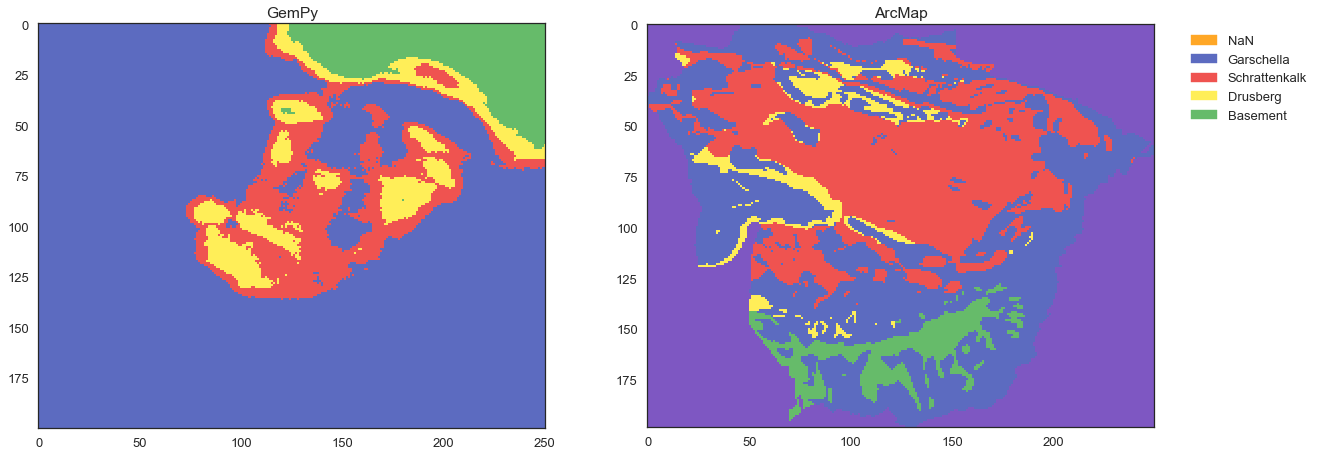

In [147]:
#Plot GemPy map next to GIS map:

fgeo,axgeo = mapping.compare_geology(surflith,geoa,colorscheme='GemPy')

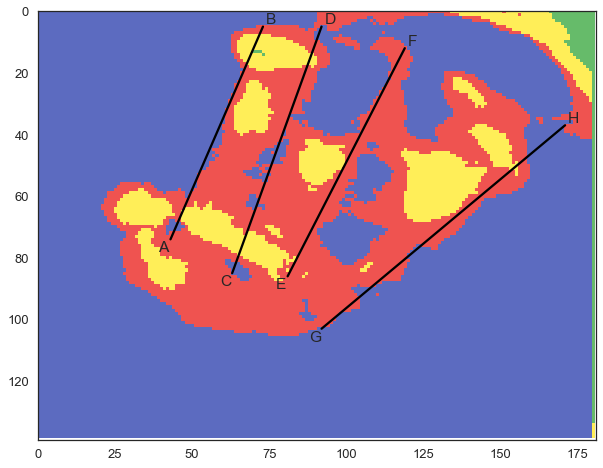

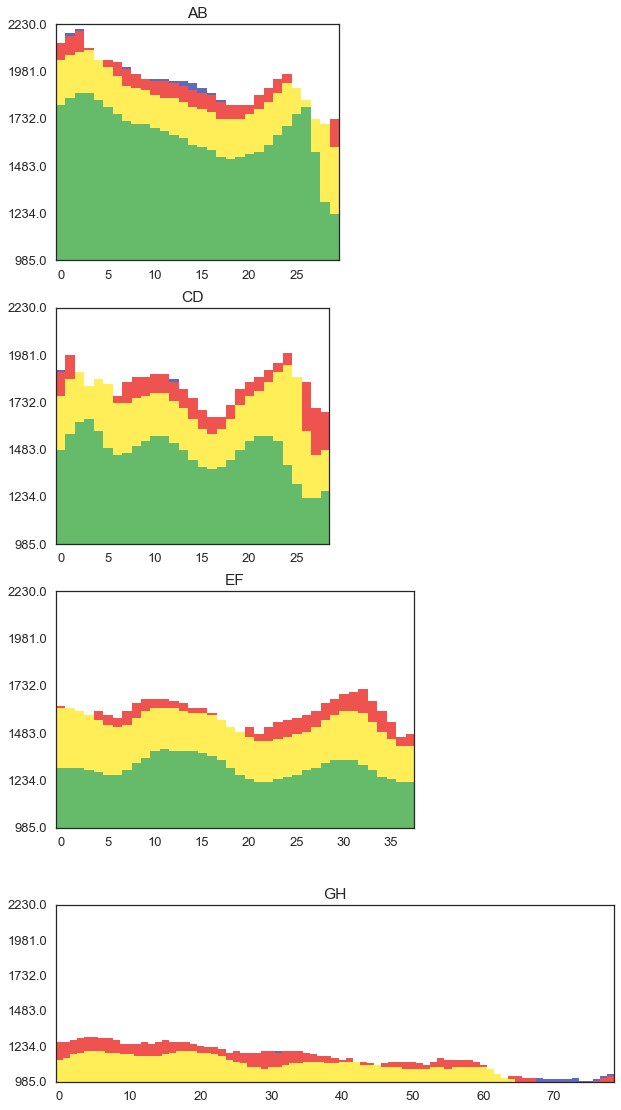

In [20]:
#Plot cross-sections:
#need two points, A and B, with x and y coordinates for each (from ArcMap)
#or can skip assigning coordinates and assign row,col directly

#Set start and end coordinates:
A = [582976.866, 5244906.859]
B = [584508.189, 5248352.204]
C = [583975.119, 5244365.344]
D = [585456.180, 5248350.638]
E = [584862.004, 5244340.385] 
F = [586787.645, 5247985.910]
G = [585417.484, 5243468.735]
H = [589363.356, 5246778.944]

f1,f2,ax2 = mapping.plotXsection([A,C,E,G],[B,D,F,H], [['A','B'],['C','D'],['E','F'],['G','H']], grid_info, lithzcrop, surflith, vscale=1)